# Bragg grating

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import shutil
from IPython import display

import meep as mp

import sys
sys.path.append('../../jupyter-meep-libs')
from meep_nb import *
import bragg_setups
from bragg_setups import bragg_cell, bragg_geometry, livefield

from lightlab.util import io
from lightlab.util.data import Spectrum, FunctionBundle, MeasuredFunction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: dlopen(/Users/atait/Sync/Documents/gitProjects/simulation-code/meep-suite/meep/python/meep/_meep.so, 0x0002): Library not loaded: /usr/local/opt/gcc/lib/gcc/9/libgfortran.5.dylib
  Referenced from: /Users/atait/Sync/Documents/gitProjects/simulation-code/meep-suite/meep/python/meep/_meep.so
  Reason: tried: '/usr/local/opt/gcc/lib/gcc/9/libgfortran.5.dylib' (no such file), '/usr/lib/libgfortran.5.dylib' (no such file)

In [2]:
io.fileDir = io.dataHome

NameError: name 'io' is not defined

In [48]:
# Do the simulation, and verify the geometry
sim = mp.Simulation(
#                     progress_interval=1e6,
                    **bragg_setups.sim_kwargs())

eps_data = show_geometry(sim)

run 0 finished at t = 160.0 (9600 timesteps)


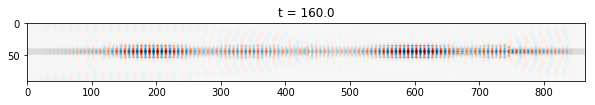

In [49]:
def plot_sim(until=200):
    sim.reset_meep()
    shutil.rmtree('outputs', ignore_errors=True)
    sim.use_output_directory('outputs')
    sim.run(
            mp.at_beginning(livefield),
            mp.at_every(5, livefield),
#             mp.at_every(1, mp.output_png(mp.Ey, "-Zc dkbluered")),
#             mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
            until=until)
    # now make the gif
#     subprocess.check_call(['convert', 'outputs/ey-*.png', 'ey.gif'])
#     subprocess.check_call(['open', '-a', 'Safari', 'ey.gif'])

plt.figure(figsize=(10,6))
plot_sim(160)

field decay(t = 220.16666666666666): 1.8021288841253794e-05 / 0.08911691326947134 = 0.0002022207477806272
run 0 finished at t = 220.16666666666666 (13210 timesteps)
Realtime duration = 14.02 seconds


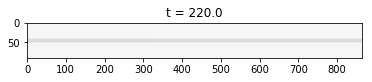

In [45]:
# Ok first do the straight waveguide
def do_baseline(do_live=True, geo=None, **kwargs):
    kwargs['dw'] = 0
    sim, refl, tran = bragg_setups.do_simrun(base_refl_data=None, do_live=do_live, geo=None, **kwargs)
    
    # for normalization run, save flux fields data for reflection plane
    straight_refl_data = sim.get_flux_data(refl)
    # This one is to normalize power. the other was to negate forward-propagating wave
    straight_tran_flux = mp.get_fluxes(tran)
    return straight_refl_data, straight_tran_flux

straight_refl_data, straight_tran_flux = do_baseline()  # comment this when you dont need to do it again

field decay(t = 800.6333333333333): 5.132350510010744e-06 / 0.006589537808044637 = 0.0007788635044699297
run 0 finished at t = 800.6333333333333 (48038 timesteps)
Realtime duration = 49.84 seconds


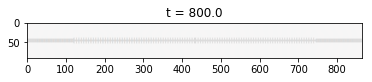

In [46]:
def do_trial(base_refl_data, do_live=True, geo=None, **kwargs):
    _, refl, tran = bragg_setups.do_simrun(base_refl_data=base_refl_data, do_live=do_live, geo=geo, **kwargs)
    return refl, tran
#     bend_refl_flux = np.array(mp.get_fluxes(refl))
#     flux_freqs = np.array(mp.get_flux_freqs(refl))
#     return bend_refl_flux, flux_freqs

refl, tran = do_trial(straight_refl_data, do_live=True)

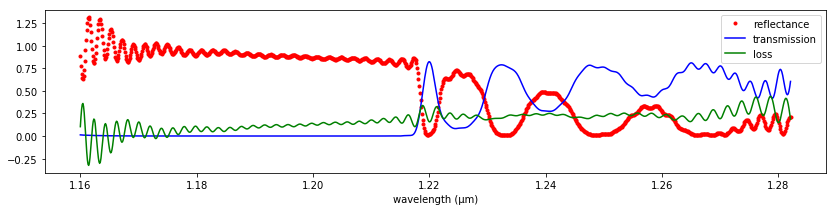

In [47]:
flux_freqs = np.array(mp.get_flux_freqs(refl))
wl = 1 / flux_freqs
Rs = -np.array(mp.get_fluxes(refl))/np.array(straight_tran_flux)
Ts = np.array(mp.get_fluxes(tran))/np.array(straight_tran_flux)
# spct = Spectrum(wl[::-1], Rs[::-1], inDbm=False)
# spct.crop([1.1,1.2]).simplePlot('.')
plt.figure(figsize=(14, 3))
plt.plot(wl,Rs,'r.',label='reflectance')
plt.plot(wl,Ts,'b-',label='transmission')
plt.plot(wl,1-Rs-Ts,'g-',label='loss')
# plt.axis([1.0, 1.44, 0, 1])
# plt.ylim([0,1])
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")



In [14]:
# parameter sweep
isResimulating = True
isSaving = False
filename = 'bragg-dw-hires.pkl'


bragg_setups.set_sim2()
# bragg_setups.resolution = 30

pname, pvals = 'n_periods', [50, 100]
# pname, pvals = 'dw', [.25, .275, .3, .35]
# pname, pvals = 'pitch', bragg_setups.default_geo.pitch + np.linspace(0, 1, 5) * .01
# pname, pvals = 'pitch', [.207]
# pname, pvals = 'buffer', [2, 4, 6, 8, 10]
# pname, pvals = 'cavity', [.25, 5.25]
# pname, pvals = 'duty', np.linspace(.4, .6, 5)

if isResimulating:
    spR = FunctionBundle()
    spT = FunctionBundle()
    spectra = (spR, spT)
    refreshing_baseline = pname in ['n_periods', 'sm_width', 'thickness', 'pitch'] or True
    if not refreshing_baseline:
        straight_refl_data, straight_tran_flux = do_baseline(do_live=False, buffer=10)
    for p in pvals:
        print()
        print(pname, '=', p)
        geo_kwarg = {pname: p}
        if refreshing_baseline:
            straight_refl_data, straight_tran_flux = do_baseline(do_live=False, **geo_kwarg)
#         bend_refl_flux, flux_freqs = do_trial(straight_refl_data, do_live=False, **geo_kwarg)
        refl, tran = do_trial(straight_refl_data, do_live=False, **geo_kwarg)
        flux_freqs = np.array(mp.get_flux_freqs(refl))
        wl = 1 / flux_freqs
        Rs = -np.array(mp.get_fluxes(refl)) / straight_tran_flux
        Ts = np.array(mp.get_fluxes(tran)) / straight_tran_flux
        spctR = Spectrum(wl[::-1], Rs[::-1], inDbm=False)
        spctT = Spectrum(wl[::-1], Ts[::-1], inDbm=False)
        spR.addDim(spctR.db())
        spT.addDim(spctT.db())
    if isSaving:
        io.savePickleGzip(dataTuple=(pname, pvals, spectra), filename=filename)
    # Notify that it is done
    applescript = """
    display dialog "Simulation is done" ¬
    with title "Pop-up window" ¬
    with icon caution ¬
    buttons {"OK"}
    """
    subprocess.call("osascript -e '{}'".format(applescript), shell=True)
else:
    pname, pvals, spectra = io.loadPickleGzip(filename=filename)



n_periods = 50
-----------
Initializing structure...
field decay(t = 20.016666666666666): 1.2530541290433853e-94 / 1.2530541290433853e-94 = 1.0
field decay(t = 40.03333333333333): 1.6086799958464266e-15 / 1.6086799958464266e-15 = 1.0
field decay(t = 60.05): 9.682770216972115e-12 / 9.682770216972115e-12 = 1.0
field decay(t = 80.05): 1.4974894385578227e-07 / 1.4974894385578227e-07 = 1.0
field decay(t = 100.06666666666666): 0.0015794019525390078 / 0.0015794019525390078 = 1.0
field decay(t = 120.08333333333333): 0.07634173648739385 / 0.07634173648739385 = 1.0
field decay(t = 140.1): 0.08633782284781145 / 0.08633782284781145 = 1.0
field decay(t = 160.11666666666667): 0.014112612583552116 / 0.08633782284781145 = 0.1634580548600184
field decay(t = 180.13333333333333): 1.089188910422103e-05 / 0.08633782284781145 = 0.00012615431736586957
run 0 finished at t = 180.13333333333333 (10808 timesteps)
Realtime duration = 6.25 seconds
-----------
Initializing structure...
field decay(t = 20.016666666

n_periods : [50, 100]


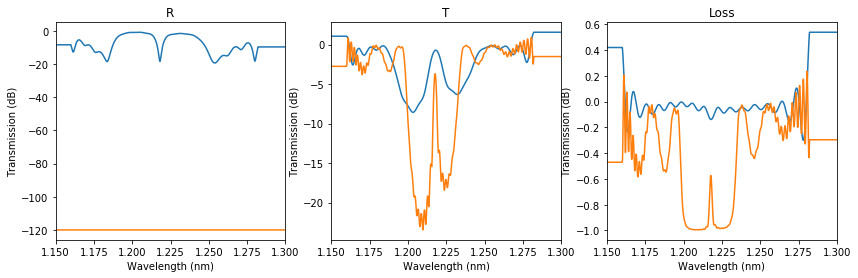

In [15]:
fi, ax = plt.subplots(ncols=3, figsize=(14, 4))
spectra = list(spectra)
spectra[0] = spectra[0].crop((1.15, 1.30))
spectra[1] = spectra[1].crop((1.15, 1.30))
plt.sca(ax[0])
spectra[0].simplePlot()
plt.title('R')
# plt.xlim([1.210, 1.230])
plt.sca(ax[1])
spectra[1].simplePlot()
plt.title('T')
# plt.xlim([1.210, 1.230])
plt.sca(ax[2])
((spectra[0].lin() + spectra[1].lin() - 1)).db().simplePlot()
plt.title('Loss')

print(pname, ':', pvals)


### To get an accurate view of loss, you need to have longer buffers
Reflection is pretty accurate at 2um
Transmission good at 4um
Loss needs 10um or 20um for perfection

### Todo
Todo: eigenmode detector flux region
Todo: multiprocessing
